# Preparing environment

In [2]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir)
src_dir = os.path.join(root_dir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)
    
import math
import copy as cp
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import preprocessing

from scipy.cluster import hierarchy
from scipy import stats
from scipy.stats import mstats

import helpers as hlp
%aimport helpers
from external import kMedoids
from IPython.display import display

#printing
pd.options.display.float_format = '{:,.2f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load preprocessed data

In [35]:
raw_path = os.path.join(root_dir,"data\\raw\\")
interim_path = os.path.join(root_dir,"data\\interim\\") 
processed_path = os.path.join(root_dir,"data\\processed\\") 

reports_path = os.path.join(root_dir,"reports\\")
models_path = os.path.join(root_dir,"models\\")

raw_file_name ="bnd_product_p2c1_raw.csv"
clean_file_name = "bnd_product_p2c1_clean.csv"
z_file_name ="bnd_product_z_p2c1_clean.csv"

row_headers = ['Product']
n_row_headers = len(row_headers)



product_raw_df = pd.read_csv(interim_path+raw_file_name, sep=';', encoding='utf-8')
product_df = pd.read_csv(interim_path+clean_file_name, sep=';', encoding='utf-8')
product_df_full = pd.read_csv(processed_path+z_file_name, sep=';', encoding='utf-8')

X_z = product_df_full.values[:,n_row_headers:]



nb_col = X_z.shape[1]
X_pca = PCA(n_components = nb_col).fit_transform(X_z)

print(product_df_full.shape)
product_df_full.head()

(326, 347)


,Product,08/12/2016,09/12/2016,10/12/2016,11/12/2016,12/12/2016,13/12/2016,14/12/2016,15/12/2016,16/12/2016,...,09/11/2017,10/11/2017,11/11/2017,12/11/2017,13/11/2017,14/11/2017,15/11/2017,16/11/2017,17/11/2017,18/11/2017
0,GBA001BND060FS,-2.66,-2.66,-2.66,-2.66,-2.66,-2.66,-2.66,-2.66,-2.66,...,-1.23,-1.47,-1.60,-1.73,-1.88,-2.03,-2.15,-2.07,-2.10,-2.13
1,GBA001BND060SS,-1.65,-1.68,-1.68,-1.61,-1.48,-1.22,-1.07,-0.63,-0.84,...,-1.68,-1.68,-1.68,-1.68,-1.68,-1.68,-1.68,-1.68,-1.68,-1.68
2,GBA001BND160FS,0.81,0.44,0.32,0.16,0.06,-0.19,-0.09,0.17,-0.14,...,0.24,-0.01,-0.05,-0.20,-0.14,-0.36,0.09,0.44,0.48,0.47
3,GBA001BND250FS,-1.75,-1.75,-1.75,-1.75,-1.75,-1.75,-1.75,-1.75,-1.75,...,1.47,1.47,1.47,1.47,1.47,1.47,1.47,1.47,1.47,1.47
4,GBA001BNR250FS,-1.12,-1.20,-1.20,-1.20,-1.20,-1.20,-1.20,-1.20,-1.20,...,1.95,1.72,1.75,1.68,1.61,1.43,1.54,1.70,1.70,1.59


### ARIMA Models

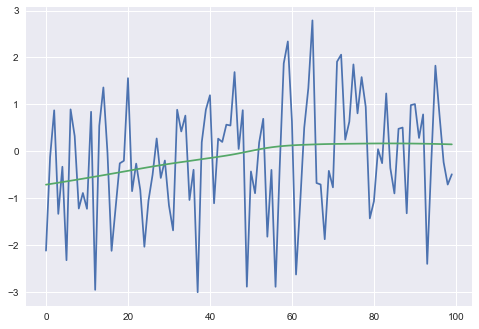

In [156]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import autocorrelation_plot
import statsmodels.api as sm

s = product_df.loc[l]
start_date = s.index[0]
nb_days = len(s)

s.index = pd.date_range(start = start_date,periods = nb_days, freq='1d')
lowess = sm.nonparametric.lowess
x = range(100)
y = np.sin(x) + np.random.normal(size=len(x))
z = lowess(y, x,return_sorted = False)
w = lowess(y, x, frac=1./3)

plt.plot(x,y)
plt.plot(x,z)
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import autocorrelation_plot
import statsmodels.api as sm
l=42

s = product_df.loc[l]
start_date = s.index[0]
nb_days = len(s)

s.index = pd.date_range(start = start_date,periods = nb_days, freq='1d')

# product_df_full.loc[l,product_df_full.columns[1:]].plot(kind='kde')
# plt.show()

display(s.head())

model = ARIMA(s[:-50], order=(0, 1, 3))

results_ARIMA = model.fit(disp=-1, trend='nc',method = 'css-mle')#start_params=(2,2)   
dim = s.shape[0]
new_dim = results_ARIMA.fittedvalues.shape[0]



rolled_df = product_df_full.rolling(window=2,axis=1,center = True,win_type=None).mean()#shift(window,axis=1)
s_values = product_df_full.values[l]
r_values = rolled_df.dropna(axis=1).values[l]


pred = results_ARIMA.predict(s,start=300)
# res = sm.tsa.seasonal_decompose(s,freq=7,model='a')
# resplot = res.plot()

# residuals = pd.DataFrame(results_ARIMA.resid)
# residuals.plot(kind='kde')


plt.figure()
plt.plot(range(0,dim),s)
plt.plot(range(dim - new_dim,dim),results_ARIMA.fittedvalues, c='red')


plt.show()

# X_z_f = []
# for i,s in enumerate(X_z):
#     model = ARIMA(s, order=(2, 1, 0))
#     results_ARIMA = model.fit(disp=-1, trend='nc') 
#     X_z_f +=[results_ARIMA.fittedvalues]

# X_z_f = np.array(X_z_f)
# print(X_z_f.shape)
